In [1]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# Mount the remote storage with the dataset
from google.colab import drive
drive.mount('/content/drive')


In [3]:
if "dataset" not in os.listdir(os.getcwd()):
    os.system("unzip -q drive/MyDrive/msa/dataset.zip")

In [2]:
# Define the directory of the dataset
data_dir = pathlib.Path('/Users/filippouslenghi/msa/dataset')
# Collects the path of all the files within the dataset
data_paths = [str(path) for path in list(data_dir.glob("*/*.jpg"))]
print(f"Images in the dataset: {len(data_paths)}")

Images in the dataset: 24951


In [3]:
# Create the respective tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices(data_paths)
# Shuffle the dataset
dataset = dataset.shuffle(len(data_paths))

Metal device set to: Apple M1 Pro


2022-07-07 15:19:30.017000: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-07 15:19:30.017328: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# Get the class names
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Cats' 'Dogs']


In [5]:
# Create a test set
test_size = int(len(list(dataset)) * 0.2)
train = dataset.skip(test_size)
test = dataset.take(test_size)

# Create a validation set
val_size = int(len(list(train)) * 0.2)
train = train.skip(val_size)
val = train.take(val_size)

In [6]:
# Set initial params for the loader
batch_size = 64
img_height = 150
img_width = 150

In [7]:
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

In [8]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [9]:
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [10]:
# Create a dataset of image, label pairs
train = train.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val = val.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test = test.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
# Configure dataset for performance
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

train = configure_for_performance(train)
val = configure_for_performance(val)
test = configure_for_performance(test)

2022-07-07 15:19:37.128831: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
2022-07-07 15:19:37.454288: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


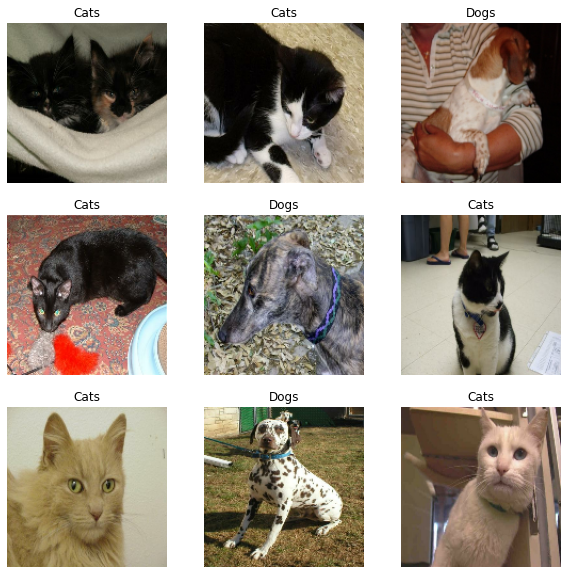

In [12]:
image_batch, label_batch = next(iter(train))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [13]:
num_classes = 1

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

In [14]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [15]:
n_epochs = 10

model.fit(
    train,
    validation_data=val,
    epochs=n_epochs
)

Epoch 1/5


2022-07-07 15:19:39.933561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 19/250 [=>............................] - ETA: 12s - loss: 0.7218 - accuracy: 0.5222

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 41/250 [===>..........................] - ETA: 11s - loss: 0.7003 - accuracy: 0.5442

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


146/250 [================>.............] - ETA: 5s - loss: 0.6613 - accuracy: 0.5991

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


186/250 [=====================>........] - ETA: 3s - loss: 0.6495 - accuracy: 0.6140

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


231/250 [==========================>...] - ETA: 1s - loss: 0.6320 - accuracy: 0.6325

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


250/250 [==============================] - ETA: 0s - loss: 0.6275 - accuracy: 0.6383

2022-07-07 15:19:55.771623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


250/250 [==============================] - 18s 62ms/step - loss: 0.6275 - accuracy: 0.6383 - val_loss: 0.5469 - val_accuracy: 0.7222
Epoch 2/5
250/250 [==============================] - 15s 58ms/step - loss: 0.5150 - accuracy: 0.7453 - val_loss: 0.4614 - val_accuracy: 0.7796
Epoch 3/5
250/250 [==============================] - 14s 54ms/step - loss: 0.4466 - accuracy: 0.7876 - val_loss: 0.4264 - val_accuracy: 0.8001
Epoch 4/5
250/250 [==============================] - 14s 58ms/step - loss: 0.4018 - accuracy: 0.8193 - val_loss: 0.3881 - val_accuracy: 0.8231
Epoch 5/5
250/250 [==============================] - 14s 56ms/step - loss: 0.3430 - accuracy: 0.8493 - val_loss: 0.3429 - val_accuracy: 0.8545


In [16]:
model.evaluate(test)

10/78 [==>...........................] - ETA: 1s - loss: 0.3520 - accuracy: 0.8531

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


47/78 [=================>............] - ETA: 0s - loss: 0.3333 - accuracy: 0.8637

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


78/78 [==============================] - 3s 29ms/step - loss: 0.3252 - accuracy: 0.8649


[0.3251816928386688, 0.8649298548698425]

In [80]:
def zero_one_loss(dataset):
    data = []
    y_truth = []

    for batch in dataset.as_numpy_iterator():
        data += [*batch[0]]
        y_truth += [*batch[1]]

    y_pred_binary = np.around(model.predict(np.asarray(data))).flatten()
    missmatches = np.logical_xor(y_pred_binary, y_truth)
    
    return tf.math.reduce_sum(tf.cast(missmatches, tf.int32)).numpy()

In [82]:
zero_one_loss(test)

156/156 [==============================] - 4s 24ms/step


674

# K-fold cross validation

In [ ]:
from random import shuffle
from sklearn.model_selection import KFold



shuffle(data_paths)
k_fold = KFold(n_splits=5)
k_splits = k_fold.split(data_paths)
results = []
zero_one_losses = []

for train_index, test_index in k_splits:

    # Clear any previous state
    del model
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()

    # Get the paths to the data
    train_paths = np.asarray(data_paths)[train_index]
    test_paths = np.asarray(data_paths)[test_index]

    # Make it tf.data.Dataset
    train = tf.data.Dataset.from_tensor_slices(train_paths)
    test = tf.data.Dataset.from_tensor_slices(test_paths)
    
    # Get labels
    train = train.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    test = test.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Configure for performance
    train = configure_for_performance(train)
    test = configure_for_performance(test)

    # Create the model
    num_classes = 1
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='sigmoid')
    ])

    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])
    
    model.fit(
        train,
        epochs=n_epochs,
        verbose=0
    )
    
    results.append(model.evaluate(test))
    zero_one_losses.append(zero_one_loss(test))

78/78 [==============================] - 9s 98ms/step - loss: 0.5467 - accuracy: 0.8214


In [ ]:
loss = np.mean(zero_one_losses)
accuracy = np.mean([result[1] for result in results])
print(loss, accuracy)

0.7889439821243286 0.7994866490364074
